# Overview: Gradient Boosting

### Introduction

Our goal is to find a function $F^*(\mathbf{x})$ that maps $x$ to $y$ such that loss function $\Psi(y, F(\mathbf{x}))$ is minimized over the joint distribution of all $(y, x)$ values

$$F^*(\mathbf{x}) = \arg \min_{F(\mathbf{x})} E_{y, \mathbf{x}} \, \Psi(y, F(\mathbf{x}))$$


Boosting: additive expansion with base learner $h(\mathbf{x}; \mathbf{a}_m)$
$$F(\mathbf{x}) = \sum_{m=0}^{M} \beta_m h(\mathbf{x}; \mathbf{a}_m)$$


### Stochastic Gradient Boosting

$$F_0(\mathbf{x}) = \arg \min_{\gamma} \sum_{i=1}^{N} \Psi(y_i, \gamma)$$


**Stochastic Gradient Tree Boosting Pseudocode**
- Init input
    - learning_rate = 0.1
    - n_esitmators = 20                 
        - this is denoted as M in the training pseudocode below
    - subsample = 0.5    
        - fraction for subsampling, if subsample<1, it is stochastic
    - min_samples = 1
        - the minimum number of samples to split for each tree
    - max_depth = 3                              
        - the maximum depth for each tree

- Train(X, Y)
    - start with an initial guess, say F(x) = mean(Y)
    - for m = 1 to M do:
        - X_batch, Y_batch = random_sampling(X, Y, fraction for subsampling (batch size))    # fraction < 1 leads to stochastic gradient boosting
        - Y_residual = negative gradient of loss between (true) Y and current F based on the batch
            - since we use (half of) sum of squared loss here
            - the gradient is thus F_m_batch-Y_batch
        - weak learner h(x) = new weakLearner.fit(X_batch, Y_residual)
        - weak learner Tree $\{R_{lm}\}_1^L$ = L-terminal node tree fitting on (X_batch, Y_residual)
            - here $\{R_{lm}\}_1^L$ represents a set of L regions (leaf nodes) in stage m
            - $R_{lm}$ represents the l-th region (leaf node) in stage m
        - $\gamma_{lm} = arg min_{\gamma} \sum_{x-batch \in R_{lm}}$ loss(Y_batch, F(x)+$\gamma$)
            - that is, for each region l at stage m, find $\gamma$ such that it minimizes the loss for the new F(x) = F(x) + $\gamma$
            - which is the mean of the sample values at region l at stage m
        - update F(x) = F(x) + learning_rate * $\gamma * 1(x \in R_{lm})$
            - that is, F(x) = F(x) + learning_rate * new tree
            - note here we are multiplying the new tree with learning rate (different from how we obtain the best $\gamma$)
    - end for

- Predict(X)
    - Given input X, predict their values
    - which is the sum of initial guess and all the weak learners' prediction
    - where each weak learner's prediction is learning_rate * $\gamma * 1(x \in R_{lm})$

- Loss(X, Y)
    - Given input examples and their true values, calculate the squared loss

In [1]:
import numpy as np


class DecisionTreeRegressor:
    def __init__(self, min_samples=1, max_depth=3):
        self.min_samples = min_samples  # Minimum number of samples
        self.max_depth = max_depth  # Maximum depth
        self.root = None  # Root node of the decision tree

    class RegressionTree:
        def __init__(self, sequence, depth=0, max_depth=3):
            self.isLeaf = True  # Whether this node is a leaf
            self.left = None  # Left subtree
            self.right = None  # Right subtree
            self.output = None  # Prediction value for the current node
            self.sequence = sequence  # Indices of samples at the current node
            self.parameter = None  # Splitting feature
            self.divide = None  # Splitting point
            self.depth = depth  # Current depth
            self.max_depth = max_depth  # Maximum depth
            self.leaf_index = id(self)  # Unique identifier for the leaf

        # Grow from the current node
        def grow(self, data, result, minnum):
            if len(self.sequence) <= minnum or self.depth >= self.max_depth:  # Stop splitting if sample size is insufficient or maximum depth is reached
                self.output = np.mean(result[self.sequence])  # Set the prediction value as the mean
                return

            # Find the best splitting feature and splitting point
            parameter, divide, err = bestdivide(data, result, self.sequence)
            left = []
            right = []

            # Split data
            for i in self.sequence:
                if data[i, parameter] < divide:
                    left.append(i)
                else:
                    right.append(i)

            # Update node information
            self.parameter = parameter
            self.divide = divide
            self.isLeaf = False
            self.left = DecisionTreeRegressor.RegressionTree(left, depth=self.depth + 1, max_depth=self.max_depth)
            self.right = DecisionTreeRegressor.RegressionTree(right, depth=self.depth + 1, max_depth=self.max_depth)

            # Recursively grow left and right subtrees
            self.left.grow(data, result, minnum)
            self.right.grow(data, result, minnum)

        # Predict a single sample
        def predict_single(self, x):
            if self.isLeaf:  # If this is a leaf node, return the prediction value
                return self.output
            if x[self.parameter] < self.divide:  # If less than the splitting point, go to the left subtree
                return self.left.predict_single(x)
            else:  # Otherwise, go to the right subtree
                return self.right.predict_single(x)
            
        # Predict leaf index for a single sample
        def predict_leaf_index_single(self, x):
            if self.isLeaf:  # If this is a leaf node, return the leaf index
                return self.leaf_index
            if x[self.parameter] < self.divide:  # If less than the splitting point, go to the left subtree
                return self.left.predict_leaf_index_single(x)
            else:  # Otherwise, go to the right subtree
                return self.right.predict_leaf_index_single(x)

    # Fit the training data
    def fit(self, X, y):
        self.root = self.RegressionTree(sequence=range(len(y)), max_depth=self.max_depth)
        self.root.grow(X, y, self.min_samples)

    # Predict the input data
    def predict(self, X):
        return np.array([self.root.predict_single(sample) for sample in X])
    
    # Predict leaf indices for the input data
    def predict_leaf_indices(self, X):
        return np.array([self.root.predict_leaf_index_single(sample) for sample in X])

# Calculate the sum of squared errors for the chosen parameter and splitting point
def squaErr(data, result, sequence, parameter, divide):
    left = []
    right = []

    for i in sequence:
        if data[i, parameter] < divide:
            left.append(i)
        else:
            right.append(i)

    if len(left) == 0 or len(right) == 0:  # If either subset is empty, return positive infinity
        return float('inf')

    c1 = np.mean(result[left])
    err1 = np.sum((result[left] - c1) ** 2)

    c2 = np.mean(result[right])
    err2 = np.sum((result[right] - c2) ** 2)

    return err1 + err2

# Determine the next splitting parameter and splitting point by exhaustive search
def bestdivide(data, result, sequence):
    min_para = 0
    sortedValue = np.sort(data[sequence][:, min_para])
    min_divide = (sortedValue[0] + sortedValue[1]) / 2
    err = squaErr(data, result, sequence, min_para, min_divide)

    for para in range(data.shape[1]):
        sortedValue = np.sort(data[sequence][:, para])
        sliceValue = (sortedValue[1:] + sortedValue[:-1]) / 2

        for divide in sliceValue:
            errNew = squaErr(data, result, sequence, para, divide)
            if errNew < err:
                err = errNew
                min_para = para
                min_divide = divide

    return min_para, min_divide, err

In [2]:
import numpy as np
import math

def squared_loss(predict, target):
    '''
    Calculates the sum of squared loss between predicted values and true values

    :param predict: a 1-d numpy array containing the predicted values
    :param target: a 1-d numpy array containing the true values
    :return loss: squared loss
    '''
    loss = 0.5*np.sum(np.power(predict-target, 2))

    return loss

class StochasticGradientBoosting:
    def __init__(self, learning_rate=0.1, n_estimators=20, subsample=0.5, min_samples=1, max_depth=3):
        """
        :param learning_rate: learning rate, default 0.1
        :param n_estimators: number of weak learners, default 20 (same as M)
        :param subsample: fraction for subsampling, default 0.5
        :param min_samples: the minimum number of samples for each tree, default 1
        :param max_depth: the maximum depth for each tree (weak learner), default 3
        """
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.subsample = subsample
        self.min_samples = min_samples
        self.max_depth = max_depth
        self.models = []    # models is a list of weak learners (decision trees)
        self.gammas = []    # gammas is a list of lists of gamma value for each tree's region
        self.initial_prediction = None  # will be initialized in train to be mean
        self.leaf_indices_dict = []     # this will store a list of leaf indices for each tree

    def train(self, X, Y):
        # initial guess F_m=mean(Y)
        self.initial_prediction = np.mean(Y)
        F_m = np.full(Y.shape, self.initial_prediction) # current F

        for m in range(self.n_estimators):
            # Random sampling for stochastic gradient boosting
            batch_size = math.floor(self.subsample*len(Y))
            indices = np.random.choice(len(Y), batch_size, replace=False)
            X_batch, Y_batch = X[indices], Y[indices]

            # Calculate residuals (negative gradient of the loss)
            residuals = Y_batch - F_m[indices]

            # Train a weak learner on the residuals
            weak_learner = DecisionTreeRegressor(min_samples=self.min_samples, max_depth=self.max_depth)
            weak_learner.fit(X_batch, residuals)
            self.models.append(weak_learner)

            # Update F_m for all samples
            leaf_indices = weak_learner.predict_leaf_indices(X)
            unique_leaves = np.unique(leaf_indices)
            self.leaf_indices_dict.append(unique_leaves)
            gamma_m = []    # the gammas for m'th tree, where each region (leaf) will have a corresponding gamma value
            for leaf_index in unique_leaves:
                region_mask = (leaf_indices == leaf_index)
                gamma = np.mean(residuals[region_mask[indices]])
                gamma_m.append(gamma)
                F_m[region_mask] += self.learning_rate * gamma
            self.gammas.append(gamma_m)

    def predict(self, X):
        # Start with the initial prediction
        F_m = np.full(X.shape[0], self.initial_prediction)

        # Add contributions from each weak learner
        for m, model in enumerate(self.models):
            leaf_indices = model.predict_leaf_indices(X)
            unique_leaves = self.leaf_indices_dict[m]
            for i, leaf_index in enumerate(unique_leaves):
                region_mask = (leaf_indices == leaf_index)
                F_m[region_mask] += self.learning_rate * self.gammas[m][i]

        return F_m

    def loss(self, X, Y):
        """calculates the squared loss given inputs and their true values"""
        pred = self.predict(X)
        loss = squared_loss(pred, Y)

        return loss

model loss: 0.3852497363255473
sklearn model loss: 0.38524973632554715
model vs sklearn model: 5.954975388045333e-30


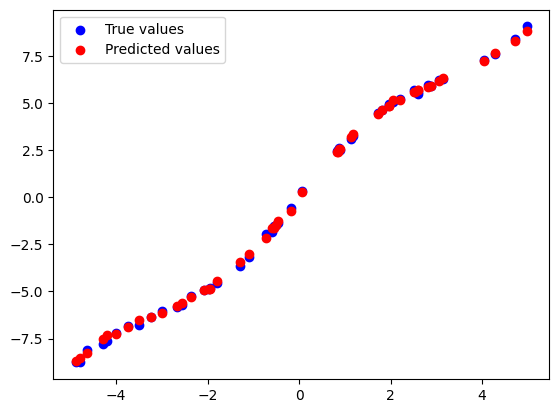

In [8]:
# toy test for the whole model -- GradientBoostingRegressor

from sklearn.ensemble import GradientBoostingRegressor

np.random.seed(1)
# set some param for testing
learning_rate=0.1
n_estimators=50     # generally, more estimators lead to better resutls
# subsample=0.5   # subsample of 1 achieves almost the same as sklearn, but subsample less than 1 causes some variation
subsample=1
min_samples=5
max_depth=3

def generate_synthetic_data(n_samples=100, noise=0.1):
    X = np.random.rand(n_samples, 1) * 10 - 5  # Random features between [-5, 5]
    Y = 2 * X.squeeze() + np.sin(X).squeeze() + np.random.randn(n_samples) * noise  # Linear + sine function + noise
    return X, Y

X_train, Y_train = generate_synthetic_data(n_samples=500)
X_test, Y_test = generate_synthetic_data(n_samples=50)

# Train the model
model = StochasticGradientBoosting(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, min_samples=min_samples, max_depth=max_depth)
model.train(X_train, Y_train)
predictions = model.predict(X_test)

# Also the sklearn model
sklearn_model = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, min_samples_split=min_samples, max_depth=max_depth)
sklearn_model.fit(X_train, Y_train)
sklearn_pred = sklearn_model.predict(X_test)
sklearn_loss = squared_loss(sklearn_pred, Y_test)

# print loss
print(f"model loss: {squared_loss(predictions, Y_test)}")
print(f"sklearn model loss: {squared_loss(sklearn_pred, Y_test)}")
print(f"model vs sklearn model: {squared_loss(predictions, sklearn_pred)}")

# Plot the results
import matplotlib.pyplot as plt
plt.scatter(X_test, Y_test, color='blue', label='True values')
plt.scatter(X_test, predictions, color='red', label='Predicted values')
plt.legend()
plt.show()


## **Check Model**

In [4]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import make_regression
import numpy as np
import pytest

# testing basic functionalities with some dummy data
def generate_data():
    np.random.seed(0)
    X = np.random.rand(100, 10)
    Y = 3 * X[:, 0] + 2 * X[:, 1] + np.random.normal(0, 0.1, 100)  #feature 1 weight 3, feature 2 weight 2
    return X, Y
    
def test_train(generate_data):
    X, Y = generate_data
    model = StochasticGradientBoosting(n_estimators=10, random_state=0)
    model.train(X, Y)
    assert len(model.models) == 10
    

def test_loss(generate_data):
    X, Y = generate_data
    model = StochasticGradientBoosting(random_state=0)
    #Y_pred = np.full_like(Y, np.mean(Y))  # using mean here as initial prediction (?)
    # loss = model.loss(Y, Y_pred)
    #assert loss > 0 



# get a public dataset


# compare model result on the dataset with sklearn result on the same dataset
#X, Y = make_regression(n_samples=100, n_features=5, noise=0.1, random_state=42)




